# Optimisation of SVM + PCA Pipeline Code
New codes written to correctly obtain the data required for measuring and plotting MI
It first plots the time series split by the origin of the data, then plots MI
Figure that we are trying to recreate:

![image.png](./image.png)

In [2]:
######### Importing Libraries in One Go #########
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wela.MIdecoding import estimate_MI, plot_MI
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

# SVM Parameter Optimisation
1) Optimise the SVM parameters to reduce runtime
2) Then find out how long each MI estimatinon would take with the optimal SVM params:
    - Crange 
    - gammarange 
3) Evaluate whether the new parameters reproduce the same results as the old parameters


## Step 1)
- Narrowing the Crange and gammarange to ``np.logspace(-2, 2, 5)`` to reduce runtime by half (theoretically, as the original search space was ``np.logspace(-3, 3, 10)``)
- Fixing the Crange and gamma range constant after a gridsearch

First, we run a benchmark experiment, where Crange and gamma range are ``np.logspace(-3, 3, 10)`` (set automatically in ``MIdecoding.py``)

Processing transcription factor: mig1
Time taken to estimate MI for mig1: 63.65 seconds
Processing transcription factor: mig2
Time taken to estimate MI for mig2: 59.03 seconds
Processing transcription factor: msn2
Time taken to estimate MI for msn2: 61.98 seconds
Processing transcription factor: msn4
Time taken to estimate MI for msn4: 85.90 seconds
Processing transcription factor: dot6
Time taken to estimate MI for dot6: 206.12 seconds
Processing transcription factor: sfp1
Time taken to estimate MI for sfp1: 105.00 seconds
Processing transcription factor: maf1
Time taken to estimate MI for maf1: 1213.21 seconds
Processing transcription factor: tod6
Time taken to estimate MI for tod6: 279.97 seconds
Processing transcription factor: hog1
Time taken to estimate MI for hog1: 1515.74 seconds
Processing transcription factor: yap1
Time taken to estimate MI for yap1: 1396.89 seconds


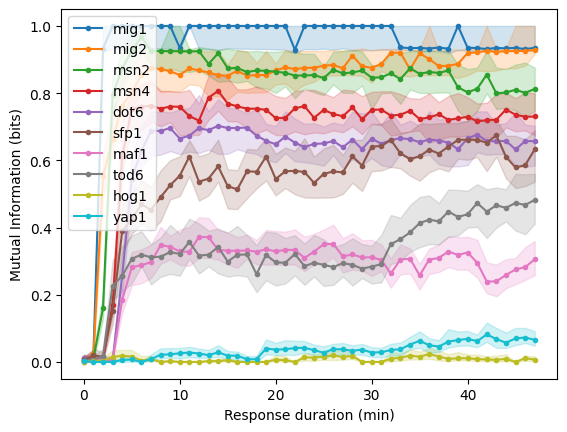

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wela.MIdecoding import estimate_MI, plot_MI
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

# Load data and define parameters
fname = "./DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"

try:
    with open(fname, "r") as f:
        expts = json.load(f)

    plt.figure()

    # Loop through each transcription factor and find optimal SVM parameters
    for transcription_factor in transcription_factors:
        print(f"Processing transcription factor: {transcription_factor}")
        
        # Load data for the transcription factor
        data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
        t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
        b_data = data[:, t[0, :] < 0]
        a_data = data[:, t[0, :] >= 0]
        minlen = np.min([b_data.shape[1], a_data.shape[1]])
        b_data = b_data[:, -minlen:]
        a_data = a_data[:, :minlen]

        # Impute missing values using multivariate imputation
        imp_mean = IterativeImputer(random_state=0)
        a_data = imp_mean.fit_transform(a_data)
        b_data = imp_mean.fit_transform(b_data)

        # Prepare data for SVM tuning
        X = np.concatenate((b_data, a_data), axis=1).T  # Transpose for (samples, features) shape
        y = np.array([0] * b_data.shape[1] + [1] * a_data.shape[1])

        # Time the MI estimation
        start_time = time.time()
        res = estimate_MI([b_data, a_data], verbose=False, overtime=True) # Note that Crange and gammarange are not specified here, and are set to default values np.logspace(-3, 3, 10) in the function
        end_time = time.time()
        estimation_time = end_time - start_time
        print(f"Time taken to estimate MI for {transcription_factor}: {estimation_time:.2f} seconds")
        
        # Plot MI result for each transcription factor
        plot_MI(res, label=transcription_factor, color=plt.cm.tab10(transcription_factors.index(transcription_factor) % 10))

    # Customize plot
    plt.xlabel("Response duration (min)")
    plt.ylabel("Mutual Information (bits)")
    plt.legend(loc="best")
    plt.show(block=False)

except FileNotFoundError:
    print("You need to download test data")
    print(f"\t{fname}")
    print("from https://doi.org/10.1073/pnas.1716659115")

Then, we run another benchmark experiment, where Crange and gamma range are ``np.logspace(-3, 3, 10)``, but this time they go through grid search before being passed onto ``MIdecoding.py`` for further gridsearch, i.e., they're fixed values after the first gridsearch. 

Processing transcription factor: mig1
Best parameters for mig1: C=0.1, gamma=0.021544346900318832
Time taken to estimate MI for mig1: 36.13 seconds
Processing transcription factor: mig2
Best parameters for mig2: C=0.001, gamma=0.001
Time taken to estimate MI for mig2: 27.55 seconds
Processing transcription factor: msn2
Best parameters for msn2: C=215.44346900318823, gamma=0.001
Time taken to estimate MI for msn2: 35.48 seconds
Processing transcription factor: msn4
Best parameters for msn4: C=2.154434690031882, gamma=0.46415888336127775
Time taken to estimate MI for msn4: 31.65 seconds
Processing transcription factor: dot6
Best parameters for dot6: C=0.001, gamma=0.46415888336127775
Time taken to estimate MI for dot6: 31.78 seconds
Processing transcription factor: sfp1
Best parameters for sfp1: C=0.001, gamma=0.021544346900318832
Time taken to estimate MI for sfp1: 27.49 seconds
Processing transcription factor: maf1
Best parameters for maf1: C=0.001, gamma=0.001
Time taken to estimate M

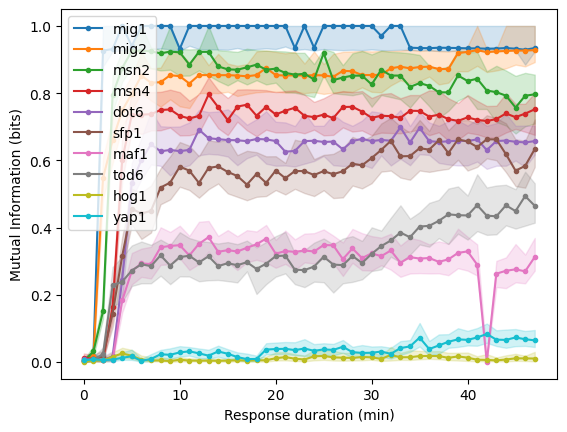

In [12]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wela.MIdecoding import estimate_MI, plot_MI
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

# Load data and define parameters
fname = "./DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"
param_grid = {
    'C': np.logspace(-3, 3, 10),
    'gamma': np.logspace(-3, 3, 10)
}

try:
    with open(fname, "r") as f:
        expts = json.load(f)

    plt.figure()

    # Loop through each transcription factor and find optimal SVM parameters
    for transcription_factor in transcription_factors:
        print(f"Processing transcription factor: {transcription_factor}")
        
        # Load data for the transcription factor
        data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
        t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
        b_data = data[:, t[0, :] < 0]
        a_data = data[:, t[0, :] >= 0]
        minlen = np.min([b_data.shape[1], a_data.shape[1]])
        b_data = b_data[:, -minlen:]
        a_data = a_data[:, :minlen]

        # Impute missing values using multivariate imputation
        imp_mean = IterativeImputer(random_state=0)
        a_data = imp_mean.fit_transform(a_data)
        b_data = imp_mean.fit_transform(b_data)

        # Prepare data for SVM tuning
        X = np.concatenate((b_data, a_data), axis=1).T  # Transpose for (samples, features) shape
        y = np.array([0] * b_data.shape[1] + [1] * a_data.shape[1])

        # Grid search for best SVM parameters
        svc = SVC()
        grid_search = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X, y)
        
        best_params = grid_search.best_params_
        print(f"Best parameters for {transcription_factor}: C={best_params['C']}, gamma={best_params['gamma']}")

        # Time the MI estimation
        start_time = time.time()
        res = estimate_MI([b_data, a_data], verbose=False, overtime=True,
                          Crange=[best_params['C']],
                          gammarange=[best_params['gamma']])
        end_time = time.time()
        estimation_time = end_time - start_time
        print(f"Time taken to estimate MI for {transcription_factor}: {estimation_time:.2f} seconds")
        
        # Plot MI result for each transcription factor
        plot_MI(res, label=transcription_factor, color=plt.cm.tab10(transcription_factors.index(transcription_factor) % 10))

    # Customize plot
    plt.xlabel("Response duration (min)")
    plt.ylabel("Mutual Information (bits)")
    plt.legend(loc="best")
    plt.show(block=False)

except FileNotFoundError:
    print("You need to download test data")
    print(f"\t{fname}")
    print("from https://doi.org/10.1073/pnas.1716659115")

The maf1 curve had a strange dip at the end... ?

Finally, we run another experiment, where Crange and gamma range are ``np.logspace(-2, 2, 5)``, with initial gridsearch for fixed Crange and gamma range values.

Processing transcription factor: mig1
Best parameters for mig1: C=1.0, gamma=0.01
Time taken to estimate MI for mig1: 47.64 seconds
Processing transcription factor: mig2
Best parameters for mig2: C=0.01, gamma=0.01
Time taken to estimate MI for mig2: 33.53 seconds
Processing transcription factor: msn2
Best parameters for msn2: C=100.0, gamma=0.01
Time taken to estimate MI for msn2: 37.07 seconds
Processing transcription factor: msn4
Best parameters for msn4: C=1.0, gamma=1.0
Time taken to estimate MI for msn4: 32.95 seconds
Processing transcription factor: dot6
Best parameters for dot6: C=1.0, gamma=1.0
Time taken to estimate MI for dot6: 34.02 seconds
Processing transcription factor: sfp1
Best parameters for sfp1: C=0.01, gamma=0.1
Time taken to estimate MI for sfp1: 26.26 seconds
Processing transcription factor: maf1
Best parameters for maf1: C=0.01, gamma=0.01
Time taken to estimate MI for maf1: 42.66 seconds
Processing transcription factor: tod6
Best parameters for tod6: C=10.0, ga

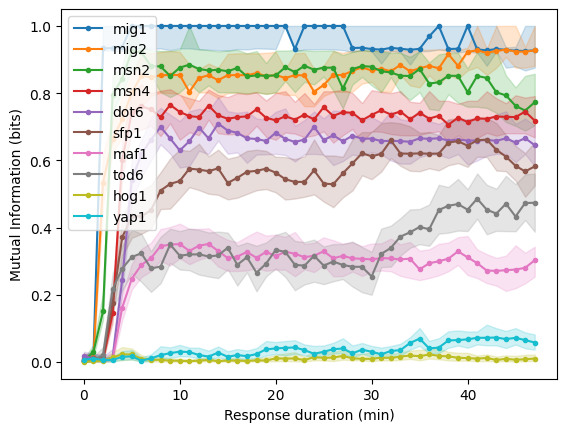

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wela.MIdecoding import estimate_MI, plot_MI
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

# Load data and define parameters
fname = "./DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"
param_grid = {
    'C': np.logspace(-2, 2, 5),
    'gamma': np.logspace(-2, 2, 5)
}

try:
    with open(fname, "r") as f:
        expts = json.load(f)

    plt.figure()

    # Loop through each transcription factor and find optimal SVM parameters
    for transcription_factor in transcription_factors:
        print(f"Processing transcription factor: {transcription_factor}")
        
        # Load data for the transcription factor
        data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
        t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
        b_data = data[:, t[0, :] < 0]
        a_data = data[:, t[0, :] >= 0]
        minlen = np.min([b_data.shape[1], a_data.shape[1]])
        b_data = b_data[:, -minlen:]
        a_data = a_data[:, :minlen]

        # Impute missing values using multivariate imputation
        imp_mean = IterativeImputer(random_state=0)
        a_data = imp_mean.fit_transform(a_data)
        b_data = imp_mean.fit_transform(b_data)

        # Prepare data for SVM tuning
        X = np.concatenate((b_data, a_data), axis=1).T  # Transpose for (samples, features) shape
        y = np.array([0] * b_data.shape[1] + [1] * a_data.shape[1])

        # Grid search for best SVM parameters
        svc = SVC()
        grid_search = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X, y)
        
        best_params = grid_search.best_params_
        print(f"Best parameters for {transcription_factor}: C={best_params['C']}, gamma={best_params['gamma']}")

        # Time the MI estimation
        start_time = time.time()
        res = estimate_MI([b_data, a_data], verbose=False, overtime=True,
                          Crange=[best_params['C']],
                          gammarange=[best_params['gamma']])
        end_time = time.time()
        estimation_time = end_time - start_time
        print(f"Time taken to estimate MI for {transcription_factor}: {estimation_time:.2f} seconds")
        
        # Plot MI result for each transcription factor
        plot_MI(res, label=transcription_factor, color=plt.cm.tab10(transcription_factors.index(transcription_factor) % 10))

    # Customize plot
    plt.xlabel("Response duration (min)")
    plt.ylabel("Mutual Information (bits)")
    plt.legend(loc="best")
    plt.show(block=False)

except FileNotFoundError:
    print("You need to download test data")
    print(f"\t{fname}")
    print("from https://doi.org/10.1073/pnas.1716659115")